In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date
import warnings

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.Strategy as ss
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def create_dogleash(df, win):
    
    dog_leash=df.copy()
    dog_leash=dog_leash.rolling(window=win).mean()
    dog_leash.dropna(inplace=True)
    c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
    dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
    dog_leash=dog_leash[['Dog_leash']]
    newcol_name=f'Dogleash_{win}'
    dog_leash.rename(columns={'Dog_leash':newcol_name}, inplace=True)
    
    return dog_leash

In [4]:
#data prepare
warnings.filterwarnings('ignore')
start=date(1990, 1, 1)
end=date(2020, 11, 23)

stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dogleash_5=create_dogleash(stock_pair, 5)
test_data=pd.merge(stock_pair, dogleash_5, how='outer', on='Date')
dogleash_20=create_dogleash(stock_pair, 20)
test_data=pd.merge(test_data, dogleash_20, how='outer', on='Date')

c=np.polyfit(test_data.iloc[:, 0], test_data.iloc[:, 1], 1)
test_data['realcombo']=-test_data.iloc[:,0]*c[0]+test_data.iloc[:,1]
#test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1556 non-null   datetime64[ns]
 1   BABA         1556 non-null   float64       
 2   BBY          1556 non-null   float64       
 3   Dogleash_5   1552 non-null   float64       
 4   Dogleash_20  1537 non-null   float64       
 5   realcombo    1556 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.1 KB


In [6]:
#################################################run model and get model's info###########################################
model=SARIMAX(test_data.loc[:,'realcombo'] , order=(4, 0, 14), trend='ct')
results=model.fit()

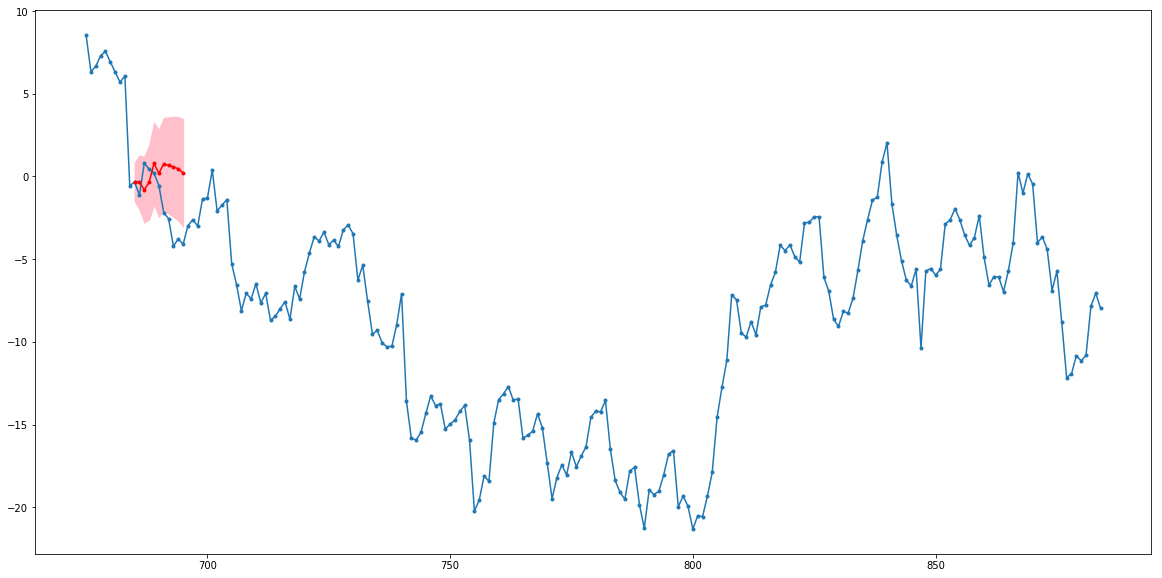

In [7]:
index=685
test_start=-len(test_data)+index
back_forecast=results.get_prediction(start=test_start, end=test_start+10, dynamic=True)
mean_forecast=back_forecast.predicted_mean
conf_intervals=back_forecast.conf_int(alpha=0.45)

#print(intervals_5)
plt.figure(figsize=(20,10))
test_data.realcombo[test_start-10:test_start+200].plot(marker='.')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='.', label='forecast_mean')

selected='realcombo'
plt.fill_between(conf_intervals.index, conf_intervals[f'lower {selected}'], conf_intervals[f'upper {selected}'], color='pink')
plt.show()



In [87]:
test_start=-1400
position=0
temp_list=[]
open_list=[]
action='-'
signal_1='-'
index_0=len(test_data)+test_start
model_start=test_start #end of the initiation section

alpha_lvl=0.45 #setting parameters
forecast_len=10
trend_tolerance=0.01
severity=1
MAX_OPEN_POSITION=4

for index in range(index_0, len(test_data)-20):
    mod_logic_1=index==index_0
    mod_logic_2=index==(mean_forecast.index[-1])
    if mod_logic_1 or mod_logic_2:
        model_start=-len(test_data)+index
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
        
    #print(f'model_start {model_start} index: {index}')
    
    too_drastic=abs(test_data.loc[index,'realcombo']-test_data.loc[index-1, 'realcombo'])>=severity
    #print(f'too drastic {too_drastic}')
    if test_data.loc[index, 'realcombo']<conf_intervals.loc[index, f'lower {selected}'] and not too_drastic:
        signal_1='up'
    elif test_data.loc[index, 'realcombo']>conf_intervals.loc[index, f'upper {selected}'] and not too_drastic:
        signal_1='down'
    else:
        signal_1='-'
    
    #print(f'signal_1: {signal_1}')
    if signal_1!='-':
        model_start=-len(test_data)+index
        #print(f'signal_1 passed; model_start {model_start}')
        back_forecast=results.get_prediction(start=model_start, end=model_start+forecast_len, dynamic=True)
        mean_forecast=back_forecast.predicted_mean
        conf_intervals=back_forecast.conf_int(alpha=alpha_lvl)
        
        mag_logic=abs((mean_forecast[index+forecast_len]/mean_forecast[index])-1)>trend_tolerance
        if mag_logic and (mean_forecast[index+forecast_len]-mean_forecast[index])>0:
            signal_2='up'
        elif mag_logic and (mean_forecast[index+forecast_len]-mean_forecast[index])<0:
            signal_2='down'
        else:
            signal_2='-'
        
        if signal_1=='up' and signal_2=='up':
            position=test_data.loc[index,'realcombo']
            if len(open_list)>0 and open_list[0][2]=='L'and len(open_list)>MAX_OPEN_POSITION: # for continued trend
                print(f"max open postion cap at index {index}")
            elif len(open_list)>0 and open_list[0][2]=='L'and len(open_list)<=MAX_OPEN_POSITION: # for continued trend
                open_list.append([index, position, 'L'])
            elif len(open_list)>0 and open_list[0][2]=='S': #trend change; need to close all open postion
                for row in open_list:
                    row.append(row[1]-position)
                temp_list.extend(open_list)
                open_list=[]
                open_list.append([index, position, 'L'])
            else : 
                open_list.append([index, position, 'L'])
                
            
        if signal_1=='down' and signal_2=='down':
            position=test_data.loc[index,'realcombo']
            if len(open_list)>0 and open_list[0][2]=='S' and len(open_list)>MAX_OPEN_POSITION: # for continued trend
                print(f"max open postion cap at index {index}")
            elif len(open_list)>0 and open_list[0][2]=='S' and len(open_list)<=MAX_OPEN_POSITION: # for continued trend
                open_list.append([index, position, 'S'])
            elif len(open_list)>0 and open_list[0][2]=='L': #trend change; need to close all open postion
                for row in open_list:
                    row.append(position-row[1])
                temp_list.extend(open_list)
                open_list=[]
                open_list.append([index, position, 'S'])
            else : 
                open_list.append([index, position, 'S'])
            

        signal_1='-'        
temp_list.extend(open_list)
    #print(index)
    #print(mean_forecast)
    #print(model_start)

max open postion cap at index 560
max open postion cap at index 637
max open postion cap at index 679
max open postion cap at index 743
max open postion cap at index 756
max open postion cap at index 766
max open postion cap at index 773
max open postion cap at index 785
max open postion cap at index 786
max open postion cap at index 792
max open postion cap at index 798
max open postion cap at index 801
max open postion cap at index 811
max open postion cap at index 822
max open postion cap at index 828
max open postion cap at index 830
max open postion cap at index 1010
max open postion cap at index 1024
max open postion cap at index 1026
max open postion cap at index 1405
max open postion cap at index 1433
max open postion cap at index 1442


In [88]:
#print(temp_list)
test_results=pd.DataFrame(temp_list, columns=['date_index', 'position',  'action','profit'])

In [89]:
test_results

date_index   position action     profit
0          168  -6.143690      L   9.605227
1          236   3.461537      S   9.437454
2          239   5.453591      S  11.429507
3          245   7.441275      S  13.417191
4          254   8.700451      S  14.676367
..         ...        ...    ...        ...
68        1472   1.438531      S   1.405989
69        1479   0.032542      L   8.507698
70        1483   8.540239      S        NaN
71        1487  11.908601      S        NaN
72        1504   4.464390      S        NaN

[73 rows x 4 columns]

In [90]:
test_results.info()
test_results.to_csv('./data/back_results_SJ.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_index  73 non-null     int64  
 1   position    73 non-null     float64
 2   action      73 non-null     object 
 3   profit      70 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.4+ KB


In [92]:
np.sum(test_results.profit)

635.2495705566105